# Integrated Simulations

In [1]:
import os; from os import listdir; from os.path import isfile, join
import re  
from skimage.io import imread
from scipy import ndimage
import trackpy as tp
from cellpose import models
from cellpose import plot
from matplotlib import gridspec
import math
import seaborn as sn                       
from joblib import Parallel, delayed
import multiprocessing
from numpy import unravel_index
# To manipulate arrays
import numpy as np 
import random
from tqdm.notebook import tqdm
from timeit import default_timer as timer
import scipy
import pandas as pd
import shutil
import pathlib
import tifffile
import sys
from skimage.exposure import rescale_intensity
import rsnapsim as rss
# Importing libraries with the watershed algorithm and local maximum detection
from scipy import ndimage as ndi              # Distance Transform
from skimage.feature import peak_local_max    # Local maxima in a matrix
from skimage.segmentation import watershed    # Watershed algorithm
from skimage.filters import gaussian # Module working with a gaussian filter
from skimage.draw import polygon
from skimage import measure
# Plotting
import matplotlib as mpl ; import matplotlib.pyplot as plt 
# To create interactive elements
import ipywidgets as widgets ; from ipywidgets import interact, interactive, fixed, interact_manual, Button, HBox, VBox, Layout, GridspecLayout ; from IPython.display import Image

In [2]:
# Defining directories
current_dir = pathlib.Path().absolute()
video_dir = current_dir.parents[1].joinpath('DataBases','moving_cells')
rsnaped_dir = current_dir.parents[1].joinpath('rsnaped')


In [3]:
#import rsnaped as rsp
sys.path.append(str(rsnaped_dir))
import rsnaped as rsp
rsp.Banner(show=True).print_banner()

 
  ██████╗░░██████╗███╗░░██╗░█████╗░██████╗░███████╗██████╗░ 
  ██╔══██╗██╔════╝████╗░██║██╔══██╗██╔══██╗██╔════╝██╔══██╗ 
  ██████╔╝╚█████╗░██╔██╗██║███████║██████╔╝█████╗░░██║░░██║ 
  ██╔══██╗░╚═══██╗██║╚████║██╔══██║██╔═══╝░██╔══╝░░██║░░██║ 
  ██║░░██║██████╔╝██║░╚███║██║░░██║██║░░░░░███████╗██████╔╝ 
             by : L. Aguilera, T. Stasevich, and B. Munsky 


In [4]:
# List all video in dir
list_files_names = sorted([f for f in listdir(video_dir) if isfile(join(video_dir, f)) and ('.tif') in f], key=str.lower)  # reading all tif files in the folder
list_files_names.sort(key=lambda f: int(re.sub('\D', '', f)))  # sorting the index in numerical order
path_files = [ str(video_dir.joinpath(f).resolve()) for f in list_files_names ] # creating the complete path for each file
path_files

['/home/luisub/Desktop/rsnaped/DataBases/moving_cells/MAX__1_MMStack_Pos1.ome.tif',
 '/home/luisub/Desktop/rsnaped/DataBases/moving_cells/MAX__1_MMStack_Pos4.ome.tif',
 '/home/luisub/Desktop/rsnaped/DataBases/moving_cells/MAX__1_MMStack_Pos6.ome.tif']

In [5]:
file_path = pathlib.Path(path_files[0])
video = imread(str(file_path)) 
img = np.expand_dims(video,axis=3)
image_optimization= np.concatenate((img,img),axis=3)

number_optimization_steps = 20

int_threshold_vector = np.round(np.linspace(0.1, 1.5, num=number_optimization_steps, endpoint=True,dtype=float),2)
cell_size_vector = np.linspace(60, 120, num=number_optimization_steps, endpoint=True,dtype=int)
model = models.Cellpose(gpu=True, model_type='nuclei') # model_type='cyto' or model_type='nuclei'
NUMBER_OF_CORES = np.min((2,multiprocessing.cpu_count()))
#NUMBER_OF_CORES = multiprocessing.cpu_count()

print(int_threshold_vector)
print(cell_size_vector)

[0.1  0.17 0.25 0.32 0.39 0.47 0.54 0.62 0.69 0.76 0.84 0.91 0.98 1.06
 1.13 1.21 1.28 1.35 1.43 1.5 ]
[ 60  63  66  69  72  75  78  82  85  88  91  94  97 101 104 107 110 113
 116 120]


In [33]:
print('image dimensions: ', img.shape)

image dimensions:  (55, 1024, 1024, 1)


In [34]:
def plotting_img(index_frame=0):

    fig, ax = plt.subplots(1,1,figsize=(12,10))
    # plotting real image
    ax.imshow(img[index_frame,:,:,0], cmap = 'Spectral_r')
    ax.set_title('Frame '+ str(index_frame))
    ax.set_xticks([]); ax.set_yticks([])
    
    plt.show()

In [35]:
index_frame = widgets.IntSlider(value=0, min=0,max=img.shape[0]-1,step=1, description='Frame:')
widgets.interact(plotting_img, index_frame=index_frame);

interactive(children=(IntSlider(value=0, description='Frame:', max=54), Output()), _dom_classes=('widget-inter…

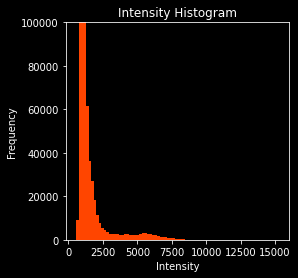

In [6]:
# Plotting the intensity distribution for a specific time point and an specific channel
plt.figure(figsize=(4,4))
plt.hist(image_optimization[0,:,:,0].flatten(), bins=80,color='orangered')
plt.xlabel('Intensity')
plt.ylabel('Frequency')
plt.ylim(0,1e5)
plt.title('Intensity Histogram')
plt.show()

In [7]:
def cells_center_of_mass(list_masks_for_all_frames):
    # Creating dataframe with centers of mass
    list_df=[]
    number_frames= list_masks_for_all_frames.shape[0]
    for i in range(number_frames):
        number_cells_in_frame = list_masks_for_all_frames[i].max()
        for m in range (1, number_cells_in_frame+1):
            selected_mask = np.where(list_masks_for_all_frames[i]==m,1,0) # Selecting only one mask.  
            x,y = ndimage.measurements.center_of_mass(selected_mask)
            list_df.append( [i,int(x),int(y)] )
            del x, y, selected_mask
    return np.array(list_df)

In [8]:
def convert_mask_labels (masks,tracking_dataframe):
    list_df=[]
    number_frames= masks.shape[0]
    list_new_masks= []
    for i in range(0,number_frames):
        # creating a copy of the original image
        temp_image = np.zeros_like(masks[0,:,:])
        trackpy_labels = tracking_dataframe.loc[tracking_dataframe['frame']==i ].particle.values
        
        # Iterate for each cell in 
        number_cells_in_frame = masks[i].max()
        for m in range (1, number_cells_in_frame+1):
            selected_mask = np.where(masks[i]==m,1,0) # Selecting only one mask.  
            for index, particle_label in enumerate (trackpy_labels):
                # Test if the center of mass is inside the selected mask 
                y, x = tracking_dataframe.loc[(tracking_dataframe['frame']==i ) & (tracking_dataframe['particle']==particle_label) , ['y', 'x']].values[0]
                if selected_mask[y,x]==1:
                    temp_image = np.where(selected_mask==1, particle_label,temp_image)
        list_new_masks.append(temp_image)
    return np.array(list_new_masks)

In [10]:
# intensity_percentile_threshold = 95
# image_test = image_optimization.copy() # Making a copy of our img
# image_test[image_test>np.percentile(image_test,intensity_percentile_threshold)]=np.percentile(image_test,intensity_percentile_threshold)  # threshold image values larger than 1000 equal to 1000
# image_test = (image_test/image_test.max()) * 255
# labels = watershed_segmentation(image_test[10,:,:,1])
# plt.imshow(labels)

In [11]:
def cellpose_segmentation(img,cell_size,model,int_threshold_vector):
    mask, _, _, _ = model.eval(img, diameter=cell_size, min_size=2000, channels=[0,0], net_avg=False, augment=False,flow_threshold=int_threshold_vector)
    return mask

In [12]:
def cell_segmentation_optimized (image_to_segment,model, intensity_percentile_threshold=99,cell_size=100,minimal_trajectory_length=10, memory_tracking=0,masks_with_trackpy_labels= True,use_cellpose=True,min_distance=100): 
    # optimization code to detected cells using multiple intensity thresholds
    image_test = image_to_segment.copy() # Making a copy of our img
    image_test[image_test>np.percentile(image_test,96)]=np.percentile(image_test,96)  # threshold image values larger than 1000 equal to 1000
    
    if use_cellpose == True:
        list_masks = Parallel(n_jobs = NUMBER_OF_CORES)(delayed(cellpose_segmentation)(image_test[index_cellpose,:,:,:],cell_size,model,intensity_percentile_threshold) for index_cellpose in range(0,image_test.shape[0]))
        masks_for_all_frames = np.array(list_masks)
    else:
        list_masks = Parallel(n_jobs = NUMBER_OF_CORES)(delayed(watershed_segmentation)(image_test[index_cellpose,:,:,0]) for index_cellpose in range(0,image_test.shape[0]))
        masks_for_all_frames = np.array(list_masks)
    try:
        area_every_frame = np.count_nonzero(masks_for_all_frames, axis=0)
        array_center_mass = cells_center_of_mass(masks_for_all_frames)
        df = pd.DataFrame(array_center_mass, columns=['frame', 'y', 'x'])
        t = tp.link(df, memory=memory_tracking,search_range=80)
        t_filtered = tp.filter_stubs(t, minimal_trajectory_length)  # selecting trajectories that appear in at least 10 frames.
        num_detected_cells = t_filtered['particle'].nunique()-1 # removing the value for the empty cell
        
        # reordering the index for the particles to have consecutive numbers
        particle_index_trackpy_values = np.unique(t_filtered['particle'].values)
        for idx, particle_number in enumerate(particle_index_trackpy_values):
            t_filtered.loc[t_filtered['particle'] == particle_number, 'particle'] = - (idx+1)
        t_filtered['particle'] = t_filtered['particle'].abs()        
        trajectory_length =  np.array( [len(t_filtered.loc[t_filtered['particle'] == i, 'frame'].values) for i in range(1, t_filtered['particle'].nunique()+1  )] )
        metric =  np.mean(area_every_frame) * np.sum(trajectory_length) * num_detected_cells
        #metric =   np.sum(trajectory_length) * num_detected_cells
    except:
        num_detected_cells = 0
        t_filtered = pd.DataFrame([], columns=['frame', 'y', 'x'])
        metric = 0
        
    if (masks_with_trackpy_labels == True) and (num_detected_cells>0) :
        masks= convert_mask_labels (masks=masks_for_all_frames,tracking_dataframe=t_filtered)
        t_filtered.rename(columns={"particle": "Cell_ID"}, inplace=True)
    else:
        masks= masks_for_all_frames        
    return metric, masks, t_filtered, image_test,num_detected_cells

In [13]:
# Optimization code
# detected_cells_matrix = np.zeros((int_threshold_vector.shape[0],cell_size_vector.shape[0] ) )
# for index_intensity, intensity_value in enumerate(tqdm(int_threshold_vector)):
#     for index_cell_size, cell_size in enumerate(cell_size_vector):
#         detected_cells_matrix[index_intensity,index_cell_size],_,_,_,_ = cell_segmentation_optimized (image_to_segment=image_optimization, intensity_percentile_threshold=intensity_value,cell_size=cell_size,model=model)

In [14]:
# detected_cells_matrix = np.zeros((int_threshold_vector.shape[0],) )
# for index_intensity, intensity_value in enumerate(tqdm(int_threshold_vector)):
#     detected_cells_matrix[index_intensity],_,_,_ = cell_segmentation_optimized (image_to_segment=image_optimization, model=model, intensity_percentile_threshold=intensity_value,use_cellpose=False)

In [15]:
# saving the numpy array
#np.save('detected_cells_matrix.npy', detected_cells_matrix)
#np.save('int_threshold_vector.npy', int_threshold_vector)
#np.save('cell_size_vector.npy', cell_size_vector)

In [16]:
# loading the numpy array
detected_cells_matrix = np.load('detected_cells_matrix.npy') 
int_threshold_vector = np.load('int_threshold_vector.npy') 
cell_size_vector = np.load('cell_size_vector.npy') 

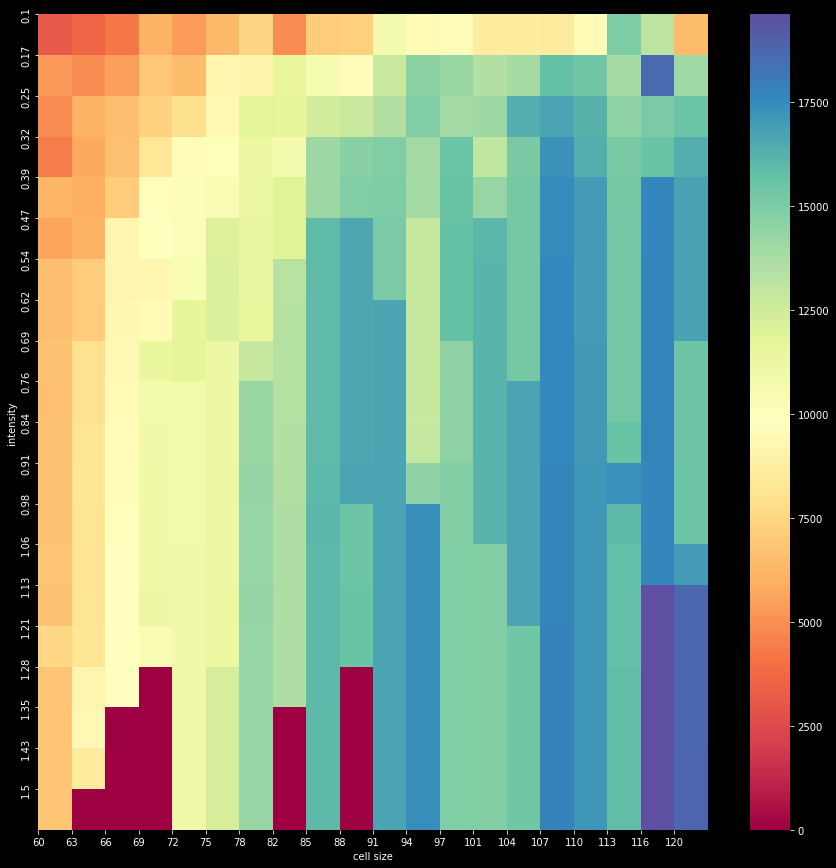

In [25]:
# showing optimization plot
tick_values= np.linspace(0, number_optimization_steps,num=number_optimization_steps,endpoint=False)
df_optimization = pd.DataFrame(detected_cells_matrix ) # Converting the image into a pandas data frame
fig, ax = plt.subplots(1,1,figsize=(15,15))
sn.heatmap(df_optimization, annot=False,cmap="Spectral",ax=ax)
ax.set_xlabel('cell size')
ax.set_ylabel('intensity')
ax.set_yticks(tick_values,int_threshold_vector)  
ax.set_xticks(tick_values,cell_size_vector)
plt.show()

In [18]:
# running for selected values
selected_intensity_index, selected_cell_size_index = unravel_index(detected_cells_matrix.argmax(), detected_cells_matrix.shape)
metric, masks_final, cell_movement_dataframe,image_optimization_selected,number_cells = cell_segmentation_optimized (image_to_segment=image_optimization, 
                                                                                                                intensity_percentile_threshold=int_threshold_vector[selected_intensity_index],
                                                                                                                cell_size=cell_size_vector[selected_cell_size_index], model=model ,
                                                                                                                masks_with_trackpy_labels= True)

In [19]:
print(int_threshold_vector[selected_intensity_index], cell_size_vector[selected_cell_size_index], int(metric), number_cells)

1.5 116 15429 10


In [20]:
#4142 189 15
# metric, masks_final, cell_movement_dataframe,image_optimization_selected, number_cells = cell_segmentation_optimized (image_to_segment=image_optimization, 
#                                                                                                                 intensity_percentile_threshold=1.5,
#                                                                                                                 cell_size=116, 
#                                                                                                                 model=model ,
#                                                                                                                 masks_with_trackpy_labels= True)
# print(int_threshold_vector[selected_intensity_index], cell_size_vector[selected_cell_size_index], metric, number_cells)

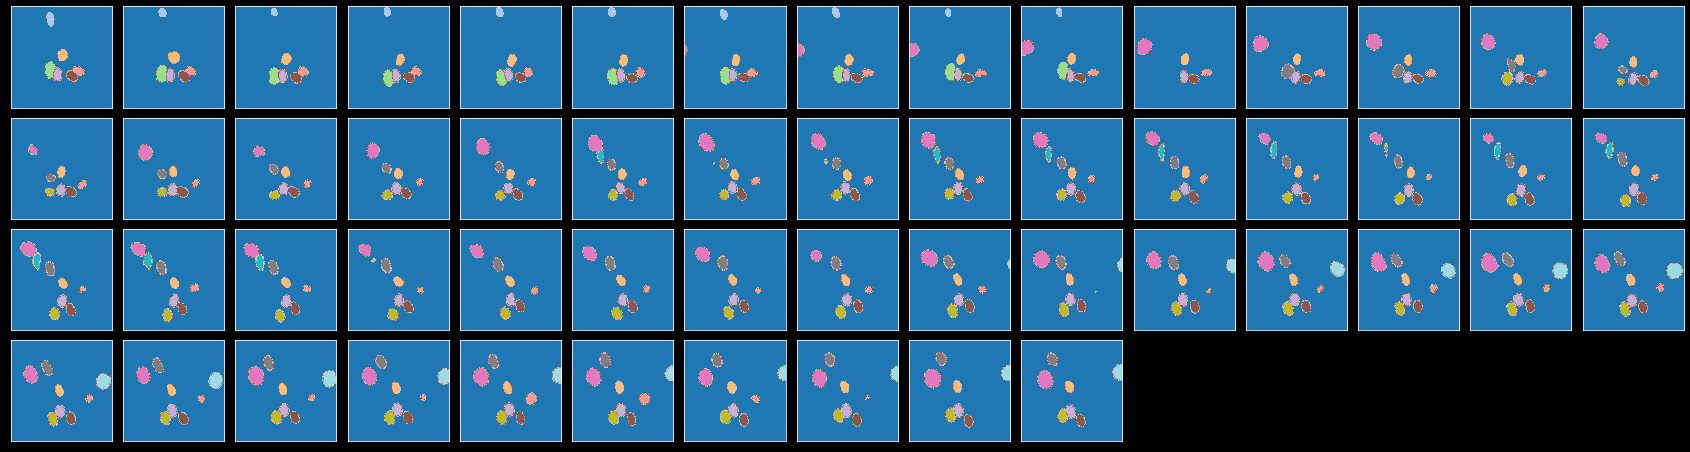

In [21]:
number_columns = 15
number_images = masks_final.shape[0]
number_rows = math.ceil(number_images/number_columns)
individual_figure_size = 2
# Loop to plot multiple cells in a grid
gs = gridspec.GridSpec(number_rows, number_columns)
gs.update(wspace = 0.1, hspace = 0.1) # set the spacing between axes.
fig = plt.figure(figsize = (individual_figure_size*number_columns, individual_figure_size*number_rows))
for index_image in range(0, number_images):
    ax = fig.add_subplot(gs[index_image])
    ax.imshow(masks_final[index_image], cmap = 'tab20',vmin=0,vmax=masks_final.max())
    ax.set_xticks([]); ax.set_yticks([])

In [36]:
number_columns = 15
number_images = image_optimization_selected.shape[0]
number_rows = math.ceil(number_images/number_columns)
individual_figure_size = 2
# intensity

# # Loop to plot multiple cells in a grid
# gs = gridspec.GridSpec(number_rows, number_columns)
# gs.update(wspace = 0.1, hspace = 0.1) # set the spacing between axes.
# fig = plt.figure(figsize = (individual_figure_size*number_columns, individual_figure_size*number_rows))
# for index_image in range(0, number_images):
#     ax = fig.add_subplot(gs[index_image])
#     ax.imshow(image_optimization_selected[index_image,:,:,0], cmap = 'Spectral',vmin=image_optimization_selected[:,:,:,0].min(),vmax=image_optimization_selected[:,:,:,0].max())
#     ax.set_xticks([]); ax.set_yticks([])

### Plotting the spots in time

In [39]:
def plotting_masks(index_frame=0):
    
    cells_ids = np.unique(cell_movement_dataframe['Cell_ID'].values)
    centers_mass = [cell_movement_dataframe.loc[(cell_movement_dataframe['Cell_ID']==selected_cell) & (cell_movement_dataframe['frame']==index_frame) ,['x','y','Cell_ID']].values for _,selected_cell in enumerate(cells_ids) ]
    array_center_mass = np.array ( [ele for ele in centers_mass if len(ele) >0])[:,0,:]
    
    fig, ax = plt.subplots(1,2,figsize=(20,10))
    # plotting real image
    ax[0].imshow(image_optimization[index_frame,:,:,0], cmap = 'Spectral_r')
    ax[0].set_title('Frame '+ str(index_frame))
    ax[0].set_xticks([]); ax[0].set_yticks([])
    
    # plotting masks
    ax[1].imshow(masks_final[index_frame], cmap = 'tab20',vmin=0,vmax=masks_final.max())
    ax[1].set_title('Frame '+ str(index_frame))
    ax[1].set_xticks([]); ax[1].set_yticks([])
    for i,cell in enumerate(array_center_mass[:,2]):
        x_val = array_center_mass[i,0]
        y_val = array_center_mass[i,1]
        ax[1].text(x=x_val-10, y=y_val-10, s=str(array_center_mass[i,2]), fontsize=12, color="Black" )
    plt.show()

In [40]:
index_frame = widgets.IntSlider(value=0, min=0,max=masks_final.shape[0]-1,step=1, description='Frame:')
widgets.interact(plotting_masks, index_frame=index_frame);

interactive(children=(IntSlider(value=0, description='Frame:', max=54), Output()), _dom_classes=('widget-inter…